# Linear Regression: Fitting Models Automatically

* Topic: Supervised machine learning
* Unit: ADS1002
* Level: Beginner
* Authors: Simon Bowly
* Version: 3

Required files (download these from the Gitlab site [here](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/tree/main/Machine-Learning/Supervised-Methods) into the same directory as the notebook on your computer):

* [who-health-data.csv](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/tree/main/Machine-Learning/Supervised-Methods/who-health-data.csv)

The objective of this notebook is to introduce the methods used to fit linear regression models. You should review last semester's linear regression work ([here](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/blob/main/Machine-Learning/Supervised-Methods/Regression/03-IntroLinearRegression.ipynb)) first. We'll see two ways in which this is implemented: ordinary least squares and gradient descent. Note that this is mainly to give a general idea of the algorithms used to fit machine learning models (in the training phase). You do not need to understand the full code, but you **should** ensure you understand the code which uses `sklearn`'s linear regression model, as this is how we will fit most models during this course.

## Recall

From previous work, you should be familiar with:

* Regression model: a model which predicts continuous output/target values based on input/feature values.
* Error metrics: mean absolute error, which measures the average difference between model predictions and actual target values.
* How to fit a linear regression model using `sklearn`: a brief example is given at the end of the notebook, but you have seen this before in last semester's linear regression work.
* Testing and training: this material covers how data is used in the training phase to fit model parameters. The testing phase, where these parameters are checked to see if they generalise to other data, is a separate step.

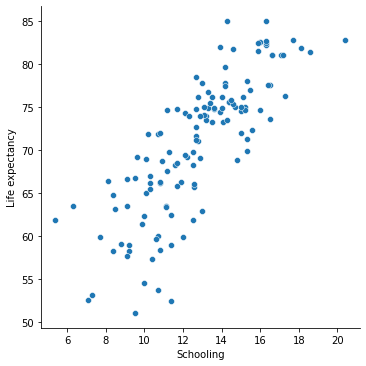

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the same datasets as we have used previously.
who_data_2015 = (
    pd.read_csv("who-health-data.csv") # Read in the csv data.
    .rename(columns=lambda c: c.strip())      # Clean up column names.
    .query("Year == 2015")                    # Restrict the dataset to records from 2015.
    # Removes two columns which contain a lot of missing data...
    .drop(columns=["Alcohol", "Total expenditure"])
    # ... then drop any rows with missing values.
    .dropna()
)
sns.relplot(data=who_data_2015, x="Schooling", y="Life expectancy");

In [2]:
pd.read_csv("who-health-data.csv")

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


## Linear Regression

As we discussed in the previous class, in supervised machine learning we aim to choose model parameters in order to minimise an error metric. We'll consider here one of the model forms from the last notebook:

$$
\text{Life expectancy} = M \times \text{Years of schooling} + C \text{ years}
$$

Last week we considered choosing model parameters by minimising mean absolute error (MAE). Linear regression, by constrast, minimises root mean squared error (RMSE):

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i \in N} \left( y^{\text{predicted}}_i - y^{\text{actual}}_i \right)^2}
$$

It is (hopefully) easy to see that the square root and division by $N$ (the number of samples) only affect the scale of the error measure, and would not change the model parameters which result in minimum error. So we can equivalent find our model parameters by minimising the following function:

$$
\min \sum_{i \in N} \left( M x_i + C - y_i \right )^2
$$

Here, $x_i$ represents years of schooling for sample point $i$, $y_i$ represents the true life expectancy values for the sample sample point, and $M$ and $C$ are the gradient and intercept, respectively, in the model. To derive this equation, we have substituted the linear model for $y^{\text{predicted}}_i$. This expression describes an **optimisation problem**, where we minimise the result over all possible values of $M$ and $C$.

The cells below first reproduce the contour plots from the last notebook to visualise the error metric (denoted by the plot colour) as a function of the selected gradient and intercept parameters in the linear model. This notebook will explore two methods for finding the optimal parameters automatically: gradient descent and ordinary least squares.

In [4]:
def prediction_root_mean_squared_error(gradient, intercept):
    """ Return the prediction error associated with the value of the parameters.
    This time around, let's use sklearn.metrics. """
    predictions = who_data_2015["Schooling"] * gradient + intercept
    actual = who_data_2015["Life expectancy"]
    # Note that `squared=False` gives us RMSE. Then we're in the same units as MAE.
    return mean_squared_error(y_true=actual, y_pred=predictions, squared=False)

def prediction_mean_absolute_error(gradient, intercept):
    """ Return the prediction error associated with the value of the parameters.
    This time around, let's use sklearn.metrics. """
    predictions = who_data_2015["Schooling"] * gradient + intercept
    actual = who_data_2015["Life expectancy"]
    return mean_absolute_error(y_true=actual, y_pred=predictions)

# Compute error values for different gradient and intercepts.
# This will be used to build the colour contour plots.
gradient_values, intercept_values = np.meshgrid(
    np.linspace(0.5, 4.0, 30),
    np.linspace(30, 80, 30),
)
rmse_errors = np.zeros(gradient_values.shape)
for i in range(rmse_errors.shape[0]):
    for j in range(rmse_errors.shape[1]):
        rmse_errors[i, j] = prediction_root_mean_squared_error(gradient_values[i, j], intercept_values[i, j])
mae_errors = np.zeros(gradient_values.shape)
for i in range(mae_errors.shape[0]):
    for j in range(mae_errors.shape[1]):
        mae_errors[i, j] = prediction_mean_absolute_error(gradient_values[i, j], intercept_values[i, j])

The contour plots below show MAE and RMSE for the same model and dataset. These plots are written as function so that they can be repeated later in the notebook. Note that they are slightly differently shaped, but the smallest error values are found in roughly the same area.

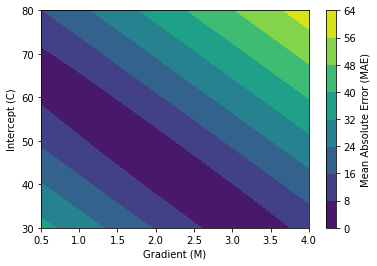

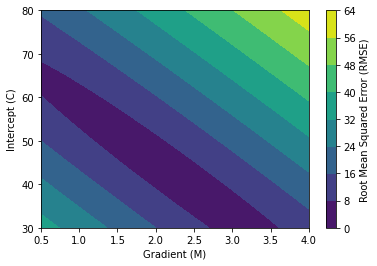

In [5]:
def mae_plot():
    plt.figure()
    plt.contourf(gradient_values, intercept_values, mae_errors)
    plt.xlabel("Gradient (M)")
    plt.ylabel("Intercept (C)")
    plt.colorbar(label="Mean Absolute Error (MAE)")

def rmse_plot():
    plt.figure()
    plt.contourf(gradient_values, intercept_values, rmse_errors)
    plt.xlabel("Gradient (M)")
    plt.ylabel("Intercept (C)")
    plt.colorbar(label="Root Mean Squared Error (RMSE)")

mae_plot()
rmse_plot()

## Error Minimisation: Gradient Descent

Instead of experimenting randomly or using some visual cues in the plots to find the best model parameters, we can use a family of algorithms called gradient descent methods to find a minimum value in the error cost function. These algorithms start with a 'guess' value for the model parameters, and try to take steps in a direction which will reduce the value of the cost function. The best direction to move in is determined by estimating the gradients of the cost function at the current point (essentially, by checking nearby points to determine the steepest downward direction.

These methods are extremely useful for broad classes of machine learning algorithms: as long as we can somehow define a cost function related to errors (which we want to minimise through a good choice of parameters) we should be able to find a good result through gradient descent. In the case of linear regression, the cost function is smooth and convex (essentially, it is a nicely shaped bowl), so we can be confident of getting a consistent result. In more complex models, we might see variations in the parameters found by gradient descent algorithms.

The code below uses a gradient descent method implemented in the `scipy` library to find the optimal model parameters. The contour plot shows the steps taken to reach the result (they are numbered in sequence). Note that it gets a little chaotic near the correct result; the algorithm takes large steps initially and small steps later on in order to reach the precise minimum value.

In [6]:
from scipy.optimize import minimize

# This sets initial guess values (gradient = 3, intercept = 60) for the algorithm to
# use as a starting point. You can change these and re-run the cell to observe the
# different paths taken by the algorithm.
initial_guess = (3, 60)

# We'll record the different model parameters tested in these lists.
gradient_steps = [initial_guess[0]]
intercept_steps = [initial_guess[1]]

def callback(values, *args, **kwargs):
    """ This function is called by `minimize` whenever it takes a step. This allows the
    steps to be recorded """
    gradient_steps.append(values[0])
    intercept_steps.append(values[1])

def prediction_error(coefficients):
    """ This function is called with both coefficients (gradient and intercept) as a tuple.
    It returns the result of the error calculation which scipy.optimise will use """
    gradient, intercept = coefficients
    return prediction_root_mean_squared_error(gradient, intercept)

# Run the gradient descent algorithm and extract the optimal model parameter values.
opt_result = minimize(
    prediction_error,      # error evaluation function
    initial_guess,         # an initial guess of the model parameters
    callback=callback,     # a function to record trial points
)

# This gives some status information and the model parameter results.
opt_result

      fun: 4.714732753471985
 hess_inv: array([[  0.62790161,  -8.00736908],
       [ -8.00736908, 106.89337695]])
      jac: array([2.38418579e-07, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 12
     njev: 17
   status: 0
  success: True
        x: array([ 2.33554636, 40.97050835])

In [7]:
from scipy.optimize import minimize

# This sets initial guess values (gradient = 3, intercept = 60) for the algorithm to
# use as a starting point. You can change these and re-run the cell to observe the
# different paths taken by the algorithm.
initial_guess = (3, 60)

# We'll record the different model parameters tested in these lists.
gradient_steps = [initial_guess[0]]
intercept_steps = [initial_guess[1]]

def callback(values, *args, **kwargs):
    """ This function is called by `minimize` whenever it takes a step. This allows the
    steps to be recorded """
    gradient_steps.append(values[0])
    intercept_steps.append(values[1])

def prediction_error(coefficients):
    """ This function is called with both coefficients (gradient and intercept) as a tuple.
    It returns the result of the error calculation which scipy.optimise will use """
    gradient, intercept = coefficients
    return prediction_root_mean_squared_error(gradient, intercept)

# Run the gradient descent algorithm and extract the optimal model parameter values.
opt_result = minimize(
    prediction_error,      # error evaluation function
    initial_guess,         # an initial guess of the model parameters
    callback=callback,     # a function to record trial points
)

# This gives some status information and the model parameter results.
opt_result

      fun: 4.714732753471985
 hess_inv: array([[  0.62790161,  -8.00736908],
       [ -8.00736908, 106.89337695]])
      jac: array([2.38418579e-07, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 12
     njev: 17
   status: 0
  success: True
        x: array([ 2.33554636, 40.97050835])

## Ordinary Least Squares

The sum-of-squared-errors cost function used for linear regression is mathematically 'nice'. In fact it's just a quadratic equation in two variables. It also happens to be a convex function, so the parameter values for minimum error can be found using simple calculus techniques. We won't go into the full derivation for now, but the key steps are to first construct the predictions as a matrix equation:

$$
y_{\text{predicted}} = X \beta
$$

where $y$ is a vector of predictions produced, $X$ is a matrix with rows and columns of the same layout as our input feature data, and $\beta$ is a vector of our unknown parameters. Note that to make this work with an intercept term, a column of ones must be added to $X$ (this produces the `+c` term in our linear equation.

In this form, the sum-of-squared-errors can be computed as:

$$
(y - X \beta)^T (y - X \beta)
$$

(each term in brackets here is a per-sample-point error value, the matrix dot product gives a sum of squares).

Differentiating this expression to find a point with zero gradient, and solving for the parameters $\beta$, gives the **Ordinary Least Squares (OLS)** estimators:

$$
\beta = (X^T X)^{-1} X^T y.
$$

No need to memorise any of these; the main point here is that OLS gives us a closed-form mathematical expression for the linear regression model parameters, so they are relatively easy to compute. However, since this is a matrix equation, when the matrices become very large (i.e. when we have a lot of data), this method can become memory intensive.

Below is a brief implementation of OLS:

NameError: name 'plot_predictions' is not defined

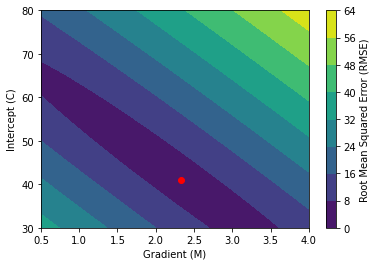

In [8]:
# Set up the data matrices X and y (note we add a column of ones to X).
X = np.matrix(who_data_2015[['Schooling']].assign(constant=1).values)
y = who_data_2015["Life expectancy"].values

# Compute the model parameters through matrix multiplication.
beta = np.linalg.inv(X.transpose() @ X) @ X.transpose() @ y
optimal_gradient, optimal_intercept = beta.tolist()[0]

# Plot the cost function contours and the parameter values which minimise it.
rmse_plot()
plt.scatter(optimal_gradient, optimal_intercept, c='r')
plot_predictions(optimal_gradient, optimal_intercept)

# Also display the prediction error.
print("Model is y = {:.2f}x + {:.2f}".format(optimal_gradient, optimal_intercept))
print("RMSE = {:.2f}".format(prediction_root_mean_squared_error(optimal_gradient, optimal_intercept)))
print("MAE = {:.2f}".format(prediction_mean_absolute_error(optimal_gradient, optimal_intercept)))

Notice that this method gives the same result. Both the OLS method and gradient descent are computationally efficient in this case. If the dataset is very large we might be better off using gradient descent, but for small data the OLS method is typically faster. Once our models get more complex (as we'll see during the rest of the semester) gradient descent will need to be used as there is no mathematical expression to directly compute the model parameters.

## In Practice: Scikit-Learn

In practice we'll use built-in functions to fit models for us. Scikit-learn's implementation of linear regression uses the OLS estimator method as above. **Focus on understanding this code** rather than the code in the previous methods, as most (if not all) of the supervised learning models you will use in this course will use almost exactly the same steps.

In [9]:
# Import the model type we need.
from sklearn.linear_model import LinearRegression

# Set up the model type. This indicates we are fitting a linear regression model
# and we want to include an intercept parameter.
model = LinearRegression(fit_intercept=True)

# It's good practice here to select only the columns needed for the analysis,
# then to remove any null values. If you don't first remove the columns you are
# not going to use, .dropna() may remove rows of data unnecessarily.
data = who_data_2015[["Schooling", "Life expectancy"]].dropna()

# Fit the model. Note: model.fit expects a 2D array of data for X and a 1D
# dataset for y (hence the double square bracket syntax when selecting columns
# for X, even though we only have one input column).
model.fit(X=data[["Schooling"]], y=data["Life expectancy"])

# Extract parameters from the model. model.coef_ gives a coefficient for each
# column of X. We are only using one input column, so the [0] element is our
# gradient parameter.
optimal_gradient = model.coef_[0]
optimal_intercept = model.intercept_

# Display the fitted model and prediction error measures.
print("Model is y = {:.2f}x + {:.2f}".format(optimal_gradient, optimal_intercept))
print("RMSE = {:.2f}".format(prediction_root_mean_squared_error(optimal_gradient, optimal_intercept)))
print("MAE = {:.2f}".format(prediction_mean_absolute_error(optimal_gradient, optimal_intercept)))

Model is y = 2.34x + 40.97
RMSE = 4.71
MAE = 3.69


## To summarise

1. In supervised learning, we need to define an error metric we are interested in which represents the predictive performance of the model.
2. To fit the parameters of a supervised machine learning model to a training dataset, we choose model parameter values so that the error metric (cost function ) is minimised.
3. For linear regression, ordinary least squares estimators give us the optimal model parameters directly. For many other methods, we will need to use gradient descent.
4. This is all implemented for us (as are all the models we'll use this semester) in the scikit-learn (sklearn) library, and the code steps required in almost all cases is the same as the example above.

## Exercises

Complete these before the studio in week 3, and submit the completed notebook through Moodle. We'll discuss the results at the end of class.

### Exercise 1

Choose a different input/feature variable (other than Schooling) and fit a regression model to predict Life Expectancy using sklearn. Can you achieve a better error rate than what we found above? Suggest a method to narrow down your choices of variables to use in order to arrive at a good model.

In [ ]:
# Hint: you can use the functions written e.g. prediction_root_mean_squared_error(gradient, intercept)
# to calculate the model error once you choose your model parameters.

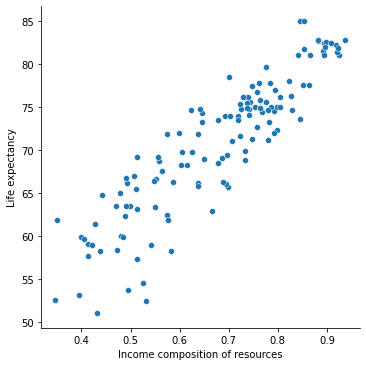

In [10]:
who_data_2015 = (
    pd.read_csv("who-health-data.csv") # Read in the csv data.
    .rename(columns=lambda c: c.strip())      # Clean up column names.
    .query("Year == 2015")                    # Restrict the dataset to records from 2015.
    # Removes two columns which contain a lot of missing data...
    .drop(columns=["Alcohol", "Total expenditure"])
    # ... then drop any rows with missing values.
    .dropna()
)
sns.relplot(data=who_data_2015, x="Income composition of resources", y="Life expectancy")

In [11]:
def prediction_root_mean_squared_error(gradient, intercept):
    """ Return the prediction error associated with the value of the parameters.
    This time around, let's use sklearn.metrics. """
    predictions = who_data_2015["Income composition of resources"] * gradient + intercept
    actual = who_data_2015["Life expectancy"]
    # Note that `squared=False` gives us RMSE. Then we're in the same units as MAE.
    return mean_squared_error(y_true=actual, y_pred=predictions, squared=False)

def prediction_mean_absolute_error(gradient, intercept):
    """ Return the prediction error associated with the value of the parameters.
    This time around, let's use sklearn.metrics. """
    predictions = who_data_2015["Income composition of resources"] * gradient + intercept
    actual = who_data_2015["Life expectancy"]
    return mean_absolute_error(y_true=actual, y_pred=predictions)

# Compute error values for different gradient and intercepts.
# This will be used to build the colour contour plots.
gradient_values, intercept_values = np.meshgrid(
    np.linspace(0.5, 4.0, 30),
    np.linspace(30, 80, 30),
)
rmse_errors = np.zeros(gradient_values.shape)
for i in range(rmse_errors.shape[0]):
    for j in range(rmse_errors.shape[1]):
        rmse_errors[i, j] = prediction_root_mean_squared_error(gradient_values[i, j], intercept_values[i, j])
mae_errors = np.zeros(gradient_values.shape)
for i in range(mae_errors.shape[0]):
    for j in range(mae_errors.shape[1]):
        mae_errors[i, j] = prediction_mean_absolute_error(gradient_values[i, j], intercept_values[i, j])

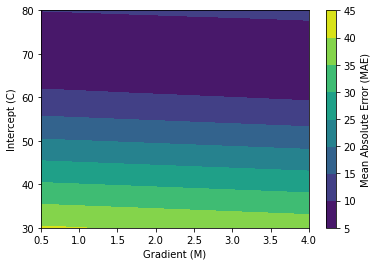

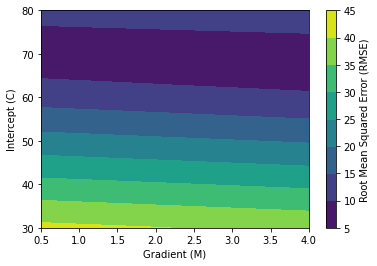

In [12]:
def mae_plot():
    plt.figure()
    plt.contourf(gradient_values, intercept_values, mae_errors)
    plt.xlabel("Gradient (M)")
    plt.ylabel("Intercept (C)")
    plt.colorbar(label="Mean Absolute Error (MAE)")

def rmse_plot():
    plt.figure()
    plt.contourf(gradient_values, intercept_values, rmse_errors)
    plt.xlabel("Gradient (M)")
    plt.ylabel("Intercept (C)")
    plt.colorbar(label="Root Mean Squared Error (RMSE)")

mae_plot()
rmse_plot()

### Exercise 2

In the above examples I have used root mean squared error (the standard cost function for linear regression) to fit the model parameters. Try re-running the `scipy.optimise` method using mean absolute error. Are the resulting model parameters the same as above? Give some brief reasoning why there might be a difference here.

In [ ]:
# Hint: you only need to make one small change in the prediction_error function to do this.

In [13]:
from scipy.optimize import minimize

# This sets initial guess values (gradient = 3, intercept = 60) for the algorithm to
# use as a starting point. You can change these and re-run the cell to observe the
# different paths taken by the algorithm.
initial_guess = (3, 60)

# We'll record the different model parameters tested in these lists.
gradient_steps = [initial_guess[0]]
intercept_steps = [initial_guess[1]]

def callback(values, *args, **kwargs):
    """ This function is called by `minimize` whenever it takes a step. This allows the
    steps to be recorded """
    gradient_steps.append(values[0])
    intercept_steps.append(values[1])

def prediction_error(coefficients):
    """ This function is called with both coefficients (gradient and intercept) as a tuple.
    It returns the result of the error calculation which scipy.optimise will use """
    gradient, intercept = coefficients
    return prediction_root_mean_squared_error(gradient, intercept)

# Run the gradient descent algorithm and extract the optimal model parameter values.
opt_result = minimize(
    prediction_error,      # error evaluation function
    initial_guess,         # an initial guess of the model parameters
    callback=callback,     # a function to record trial points
)

# This gives some status information and the model parameter results.
opt_result

      fun: 3.504293642545179
 hess_inv: array([[ 154.430769  , -104.18134384],
       [-104.18134384,   73.86560564]])
      jac: array([-1.66893005e-06, -2.47359276e-06])
  message: 'Optimization terminated successfully.'
     nfev: 48
      nit: 10
     njev: 16
   status: 0
  success: True
        x: array([47.49583203, 38.69170766])

Model is y = 47.50x + 38.69
RMSE = 3.50
MAE = 2.74


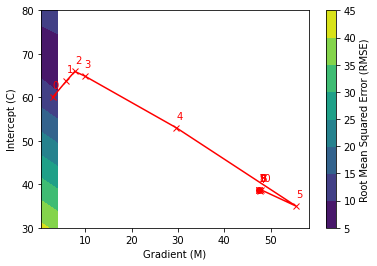

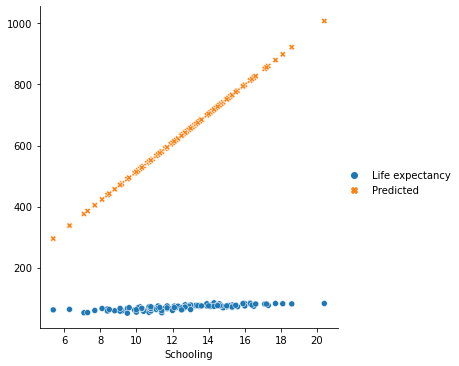

In [14]:
def plot_gradient_descent_path(gvals, ivals):
    """ Plots the path taken to find the minimum value. """
    plt.plot(gvals, ivals, 'r-x')
    for n, (g, i) in enumerate(zip(gvals, ivals)):
        plt.text(g + 0.02, i + 2, str(n), color='r')
    plt.scatter(gvals[-1], ivals[-1], c='r')

def plot_predictions(gradient, intercept):
    """ Plot the model predictions using the given parameters. """
    # Generate predictions using the selected gradient and intercept.
    who_with_predictions = (
        who_data_2015[["Schooling", "Life expectancy"]]
        # Add a column with a computed prediction based on years of schooling.
        .assign(Predicted=lambda df: df["Schooling"] * gradient + intercept)
        # Discard for the moment any row where we can't make a prediction
        # due to missing data.
        .dropna()
    )
    # Plot both the predicted and actual life expectancy results against years of schooling.
    sns.relplot(data=who_with_predictions.set_index("Schooling"));

optimal_gradient, optimal_intercept = opt_result.x
rmse_plot()
plot_gradient_descent_path(gradient_steps, intercept_steps)
plot_predictions(optimal_gradient, optimal_intercept)

# Display the model and prediction error.
print("Model is y = {:.2f}x + {:.2f}".format(optimal_gradient, optimal_intercept))
print("RMSE = {:.2f}".format(prediction_root_mean_squared_error(optimal_gradient, optimal_intercept)))
print("MAE = {:.2f}".format(prediction_mean_absolute_error(optimal_gradient, optimal_intercept)))

### Exercise 3

We can see above that different methods for determining model parameters arrive at the same result, but what happens if we change the dataset slightly. Experiment by taking several (at least 10) different samples of the data, fitting a linear model for each one, and plotting a histogram of the different gradient and intercept coefficients you find. Is there a significant amount of variation in the parameter values?

In [15]:
sample_data = who_data_2015.sample(30)  # selects a small sample of 30 random rows from the data.

In [16]:
sample_data

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1667,Mauritius,2015,Developing,74.6,146.0,0,0.000000,97.0,0,33.3,0,98.0,97.0,0.1,9252.117240,126265.0,6.9,6.8,0.779,15.2
448,Cabo Verde,2015,Developing,73.3,114.0,0,0.000000,96.0,0,31.3,0,93.0,93.0,0.2,2954.119467,532913.0,6.6,6.6,0.646,13.5
2649,Trinidad and Tobago,2015,Developing,71.2,17.0,0,0.000000,9.0,0,47.1,0,88.0,96.0,0.3,17321.833730,13692.0,5.7,5.9,0.779,12.7
2441,Sri Lanka,2015,Developing,74.9,138.0,3,0.000000,99.0,1568,23.4,3,99.0,99.0,0.1,3844.891230,2966.0,15.1,15.0,0.764,14.0
336,Botswana,2015,Developing,65.7,256.0,2,0.000000,95.0,0,37.9,2,96.0,95.0,2.2,6532.651000,229197.0,6.4,6.1,0.698,12.6
2265,Serbia,2015,Developing,75.6,121.0,1,0.000000,94.0,383,6.0,1,95.0,95.0,0.1,5237.255334,795383.0,2.0,2.0,0.775,14.4
1813,Nepal,2015,Developing,69.2,165.0,17,0.000000,91.0,1599,19.1,21,9.0,91.0,0.1,743.765349,28656282.0,15.7,16.1,0.555,12.2
1362,Kenya,2015,Developing,63.4,249.0,54,0.000000,89.0,95,22.0,75,83.0,89.0,2.8,1349.971440,47236259.0,7.8,7.6,0.550,11.1
0,Afghanistan,2015,Developing,65.0,263.0,62,71.279624,65.0,1154,19.1,83,6.0,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
144,Azerbaijan,2015,Developing,72.7,118.0,5,0.000000,96.0,0,52.5,6,98.0,96.0,0.1,55.313820,9649341.0,2.8,2.9,0.758,12.7


Model is y = 41.42x + 43.67
RMSE = 3.73
MAE = 2.76


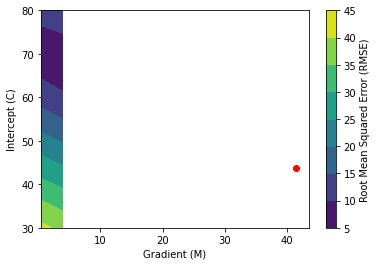

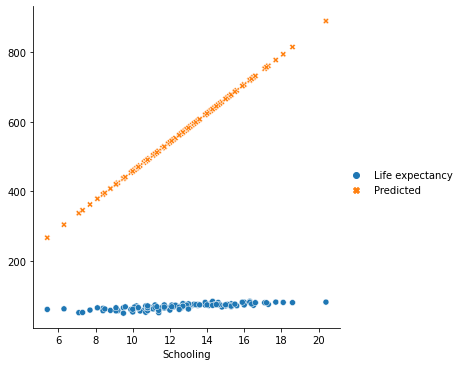

In [17]:

X = np.matrix(sample_data[['Income composition of resources']].assign(constant=1).values)
y = sample_data["Life expectancy"].values


beta = np.linalg.inv(X.transpose() @ X) @ X.transpose() @ y
optimal_gradient, optimal_intercept = beta.tolist()[0]


rmse_plot()
plt.scatter(optimal_gradient, optimal_intercept, c='r')
plot_predictions(optimal_gradient, optimal_intercept)


print("Model is y = {:.2f}x + {:.2f}".format(optimal_gradient, optimal_intercept))
print("RMSE = {:.2f}".format(prediction_root_mean_squared_error(optimal_gradient, optimal_intercept)))
print("MAE = {:.2f}".format(prediction_mean_absolute_error(optimal_gradient, optimal_intercept)))

In [18]:
X

matrix([[0.779, 1.   ],
        [0.646, 1.   ],
        [0.779, 1.   ],
        [0.764, 1.   ],
        [0.698, 1.   ],
        [0.775, 1.   ],
        [0.555, 1.   ],
        [0.55 , 1.   ],
        [0.479, 1.   ],
        [0.758, 1.   ],
        [0.764, 1.   ],
        [0.741, 1.   ],
        [0.701, 1.   ],
        [0.399, 1.   ],
        [0.406, 1.   ],
        [0.787, 1.   ],
        [0.738, 1.   ],
        [0.919, 1.   ],
        [0.768, 1.   ],
        [0.642, 1.   ],
        [0.733, 1.   ],
        [0.741, 1.   ],
        [0.882, 1.   ],
        [0.894, 1.   ],
        [0.863, 1.   ],
        [0.548, 1.   ],
        [0.896, 1.   ],
        [0.734, 1.   ],
        [0.853, 1.   ],
        [0.47 , 1.   ]])

[array([74.6, 73.3, 71.2, 74.9, 65.7, 75.6, 69.2, 63.4, 65. , 72.7, 75.8,
        74.1, 78.5, 59.9, 59.6, 75. , 74.9, 82.2, 74.4, 74.8, 68.8, 74.8,
        82.8, 82.4, 77.6, 66.4, 82. , 76.1, 81.7, 63.5])]

In [23]:
pd.merge(sample_data["Life expectancy"],sample_data["Income composition of resources"],on="Life expectancy")

KeyError: 'Life expectancy'

In [30]:
plt.hist(x=sample_data["Income composition of resources"], y=sample_data["Life expectancy"])

(array([2., 3., 4., 1., 1., 3., 5., 4., 4., 3.]),
 array([0.347 , 0.4047, 0.4624, 0.5201, 0.5778, 0.6355, 0.6932, 0.7509,
        0.8086, 0.8663, 0.924 ]),
 <BarContainer object of 10 artists>)

ValueError: setting an array element with a sequence.

<Figure size 432x288 with 1 Axes>

In [23]:
gvals[-1]

NameError: name 'gvals' is not defined